## Import 및 함수정의

In [1]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

# Modeling algorithms
# General
import statsmodels.api as sm
from scipy import stats

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree, export_text, export_graphviz
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from xgboost import plot_importance as plot_importance_xgb
from lightgbm import plot_importance as plot_importance_lgbm
from catboost import Pool, CatBoostClassifier
from mlxtend.classifier import StackingClassifier, StackingCVClassifier
from mlxtend.plotting import plot_decision_regions

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

# Evaluation metrics
from sklearn import metrics
# for classification
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             roc_curve, auc, precision_score, recall_score, f1_score)

from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
import shap 

from matplotlib import font_manager, rc # 폰트 세팅을 위한 모듈 추가
font_path = "C:/Windows/Fonts/malgun.ttf" # 사용할 폰트명 경로 삽입
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

In [2]:
# 함수 정의
def datasplit(df, Y_colname, test_size=0.2, random_state=123):
    X_colname = [x for x in df.columns if x not in Y_colname]

    
    X_train, X_test, Y_train, Y_test = train_test_split(df[X_colname], df[Y_colname],
                                                        test_size=test_size, random_state=random_state, stratify=df[Y_colname])
    print(X_train.shape, Y_train.shape)
    print(X_test.shape, Y_test.shape)
    print('Data Split!')
    
    return X_train, X_test, Y_train, Y_test
    #X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

    #scaler = preprocessing.MinMaxScaler()
def scale(scaler, X_train, X_test):
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train), 
                               index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                              index=X_test.index, columns=X_test.columns)
    return X_train_scaling, X_test_scaling
    #X_train_scaled, X_test_scaled = scale(scaler, X_train, X_test)
    #print(X_train_scaled.shape, Y_train.shape)
    #print(X_test_scaled.shape, Y_test.shape)

def preprocessing_Engagement(df) :
  
    # 비형식학습 참여 집단
    Y_colname = ['비형식교육 참여자']
    
    # 데이터 분리
    X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

    # 샘플링
    if df[Y_colname].value_counts().sort_values(ascending=False).index[0] == 0:
        sampling_method = 'RandomUnderSampler'
        sampler, X_train, Y_train = undersampling(X_train, Y_train,
                                                    method=sampling_method, strategy=sampling_strategy,
                                                    random_state=random_state)
    else:
        sampling_method = 'SMOTE' # 'SMOTETomek' #'ADASYN'
        sampler, X_train, Y_train = oversampling(X_train, Y_train, 
                                                         method=sampling_method, strategy=sampling_strategy, 
                                                         random_state=random_state)
    
    #스케일 조정
    scaler = preprocessing.MinMaxScaler()
    X_train_scaled, X_test_scaled = scale(scaler, X_train, X_test)
    print(X_train_scaled.shape, Y_train.shape)
    print(X_test_scaled.shape, Y_test.shape)
    
    return X_train_scaled, X_test_scaled, Y_train, Y_test

def preprocessing_Satisfaction(df) :
    Y_colname = ['평생학습 만족여부']
    test_size = 0.2
    random_state = 123
    
    # 종속변수 및 독립변수 설정
    X_colname = [x for x in df.columns if x not in [Y_colname, '비형식교육 참여자']]
    print(df[Y_colname].value_counts())

    # 데이터 분리
    X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)
    
    # 샘플링
    if df[Y_colname].value_counts().sort_values(ascending=False).index[0] == 0:
        sampling_method = 'RandomUnderSampler'
        sampler, X_train, Y_train = undersampling(X_train, Y_train,
                                                    method=sampling_method, strategy=sampling_strategy,
                                                    random_state=random_state)
    else:
        sampling_method = 'SMOTE' # 'SMOTETomek' #'ADASYN'
        sampler, X_train, Y_train = oversampling(X_train, Y_train, 
                                                         method=sampling_method, strategy=sampling_strategy, 
                                                         random_state=random_state)
    
    #스케일 조정
    scaler = preprocessing.MinMaxScaler()
    X_train_scaled, X_test_scaled = scale(scaler, X_train, X_test)
    print(X_train_scaled.shape, Y_train.shape)
    print(X_test_scaled.shape, Y_test.shape)
    
    return X_train_scaled, X_test_scaled, Y_train, Y_test

def undersampling(X_train, Y_train, method='OneSidedSelection', strategy='auto', random_state=123):
    print('Ratio of Origin Y: ', Y_train.value_counts())
    if method == 'RandomUnderSampler':
        sampler = RandomUnderSampler(sampling_strategy=strategy, random_state=random_state)
    elif method == 'TomekLinks':
        sampler = TomekLinks(sampling_strategy=strategy)
    elif method == 'CondensedNearestNeighbour':
        sampler = CondensedNearestNeighbour(sampling_strategy=strategy, random_state=random_state)
    elif method == 'OneSidedSelection':
        sampler = OneSidedSelection(sampling_strategy=strategy, random_state=random_state)
        
    # 축소
    X_train, Y_train = sampler.fit_resample(X_train, Y_train)
    print('Ratio of Sapling Y: ', Y_train.value_counts())
    
    return sampler, X_train, Y_train


def oversampling(X_train, Y_train, method='SMOTE', strategy='auto', random_state=123):
    print('Ratio of Origin Y: ', Y_train.value_counts())

    if method == 'SMOTE':
        sampler = SMOTE(sampling_strategy=strategy, random_state=random_state)
    elif method == 'ADASYN':
        sampler = ADASYN(sampling_strategy=strategy, random_state=random_state)
    elif method == 'BorderlineSMOTE':
        sampler = BorderlineSMOTE(sampling_strategy=strategy, random_state=random_state)

    # 오버샘플링 수행
    X_train, Y_train = sampler.fit_resample(X_train, Y_train)
    print('Ratio of Sampling Y: ', Y_train.value_counts())

    return sampler, X_train, Y_train

# Confusion Matrix 함수화
def evaluation_class_ConfusionMatrix(Y_true, Y_pred):
    conf_mat = confusion_matrix(Y_true>=0.5, Y_pred)
    conf_mat = pd.DataFrame(conf_mat, 
                            index=['True: 0', 'True: 1'], 
                            columns=['Pred: 0', 'Pred: 1'])
    
    return conf_mat


# Classification Report 함수화
def evaluation_class_ClassificationReport(Y_true, Y_pred):
    print(classification_report(Y_true, Y_pred, 
                                target_names=['class 0', 'class 1']))


# ROC Curve & AUC 함수화
def evaluation_class_ROCAUC(Y_true, P_pred, figsize=(10,5)):
    fpr, tpr, thresholds = roc_curve(Y_true, P_pred)
    cm = evaluation_class_ConfusionMatrix(Y_true, P_pred>=0.5)
    recall = cm.iloc[1,1] / cm.sum(axis=1).values[1]
    fallout = cm.iloc[0,1] / cm.sum(axis=1).values[0]
    
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, label='Logistic Regression')
    plt.plot([0, 1], [0, 1],'r--')
    plt.plot([fallout], [recall], 'ro', ms=10)
    plt.title('AUC: ' + str(auc(fpr, tpr)), fontsize=15)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=12)
    plt.grid()
    plt.show()


# Precision & Recall Curve 함수화
def evaluation_class_PrecisionRecall(Y_true, P_pred, figsize=(10,5)):
    pre, rec, thresholds = precision_recall_curve(Y_true, P_pred)
    
    plt.figure(figsize=figsize)
    plt.plot(thresholds, pre[:-1], label='Precision')
    plt.plot(thresholds, rec[1:], label='Recall')
    plt.xlabel('Threshold', fontsize=15)
    plt.ylabel('', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=12)
    plt.grid()
    plt.show()


def evaluation_class_AccuracyAUC(Y_real, Y_pred_prob):
    # 0.5 기준으로 확률을 이진 레이블로 변환하여 accuracy 계산
    Y_pred_label = np.where(Y_pred_prob >= 0.5, 1, 0)
    accuracy = accuracy_score(Y_real, Y_pred_label)
    roc_auc = roc_auc_score(Y_real, Y_pred_prob)  # 확률 값을 그대로 사용
    result = pd.DataFrame({'Accuracy': [accuracy], 'ROC_AUC': [roc_auc]})

    # 소수점 5자리까지 표시
    result = result.applymap(lambda x: '{:.5f}'.format(x))
    return result

def evaluation_class_AccuracyAUC_trte(Y_real_tr, Y_pred_tr_prob, Y_real_te, Y_pred_te_prob):
    Score_tr = evaluation_class_AccuracyAUC(Y_real_tr, Y_pred_tr_prob)
    Score_te = evaluation_class_AccuracyAUC(Y_real_te, Y_pred_te_prob)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    # 소수점 5자리까지 표시
    Score_trte = Score_trte.applymap(lambda x: '{:.5f}'.format(float(x)))
    return Score_trte

## EngagementClassification

In [3]:
Y_colname = '비형식교육 참여자'
test_size = 0.2
random_state = 123
sampling_strategy = 'auto'
SAMPLING_METHOD = 'RandomUnderSampler'
SAMPLING_STRATEGY = 'auto'
numeric_columns = [
    'DQ3. 몇 명과 함께 지내고 있습니까?__명',
    'DQ12. 귀하의 현재 직장에서의 근무기간은 얼마나 되십니까?__년',
    'DQ12. 귀하의 현재 직장에서의 근무기간은 얼마나 되십니까?__개월'
]
# DQ컬럼과 중복
deleted_cols = ['학력별', '자녀유무 및 막내자녀 상태', '동거가족 유무', '부양가족 유무', '취학 전의 손자/손녀 유무', '건강에 대한 자신감', '고용형태', '직업', '직장의 규모', '근무기간']

# 데이터로딩 및 데이터 불러오기    
df = pd.read_csv('./df_prep.csv', encoding='utf-8-sig')

# 더미 생성
dq_cat_cols = [col for col in df.columns if col.startswith('DQ') and col not in numeric_columns]
dummy_cols = dq_cat_cols + ['문C1) 앞으로 참여하길 희망하는 프로그램은 무엇입니까? (중복응답)1']
df = pd.get_dummies(df, columns=dummy_cols, drop_first=True)
df.drop(columns=deleted_cols, inplace=True)

X_train_scaled, X_test_scaled, Y_train, Y_test = preprocessing_Engagement(df)


(41095, 100) (41095, 1)
(10274, 100) (10274, 1)
Data Split!
Ratio of Origin Y:  비형식교육 참여자
0            26601
1            14494
Name: count, dtype: int64
Ratio of Sampling Y:  비형식교육 참여자
0            26601
1            26601
Name: count, dtype: int64
(53202, 100) (53202, 1)
(10274, 100) (10274, 1)


In [4]:
## 전반적인 모델링 성능 확인

# 모델 정의 
models = {
    'Logistic Regression' : LogisticRegression(fit_intercept=False),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=123),
    'XGBoost': XGBClassifier(n_estimators=100,
                          learning_rate=0.1,
                          max_depth=3, random_state=123,
                          eval_metric='mlogloss'),
    'LightGBM': LGBMClassifier(n_estimators=100,
                            learning_rate=0.1,
                            max_depth=3, random_state=123),
    'CatBoost': CatBoostClassifier(n_estimators=100,
                              learning_rate=0.1,
                              max_depth=3, random_state=123,
                              verbose=0),
}

# 모델 학습 및 평가
results = []

for name, model in models.items():
    print(f'------{name}------')
    
    model.fit(X_train_scaled, Y_train)
    y_pred = model.predict(X_test_scaled)

    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test_scaled)

    # 평가 지표
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)


    cm = confusion_matrix(Y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)


    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # 결과 저장
    results.append({
        'Algorithm': name,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-score': f1,
        'Accuracy': accuracy,
        'AUC': roc_auc
    })

results_df_del = pd.DataFrame(results)
# 소수점 6자리까지 표시
results_df_del = results_df_del.applymap(lambda x: '{:.6f}'.format(x) if isinstance(x, (int, float)) else x)

------Logistic Regression------
------Random Forest------
------XGBoost------
------LightGBM------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 26601, number of negative: 26601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2086
[LightGBM] [Info] Number of data points in the train set: 53202, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

In [5]:
results_df_del

,Algorithm,Precision,Recall,Specificity,F1-score,Accuracy,AUC
0,Logistic Regression,0.575287,0.511455,0.794317,0.541496,0.694569,0.726037
1,Random Forest,0.641346,0.552305,0.831755,0.593504,0.733210,0.782573
2,XGBoost,0.595676,0.562793,0.791911,0.578768,0.711115,0.753855
3,LightGBM,0.595420,0.559757,0.792813,0.577038,0.710629,0.753786
4,CatBoost,0.607400,0.512007,0.819726,0.555639,0.711213,0.754389


## XGBOOST

(41095, 100) (41095, 1)
(10274, 100) (10274, 1)
Data Split!
Ratio of Origin Y:  비형식교육 참여자
0            26601
1            14494
Name: count, dtype: int64
Ratio of Sampling Y:  비형식교육 참여자
0            26601
1            26601
Name: count, dtype: int64
(53202, 100) (53202, 1)
(10274, 100) (10274, 1)
변수 중요도(분류기준): 


,Importance
문A3-1) 귀하께서는 작년에 다음과 같은 학습에 참여해 본 적이 있으십니까?__가족^ 친구 또는 직장동료^ 상사의 도움이나 조언을 통해 지식을 습득한 적이 있다,0.02
문A3-2) 귀하께서는 작년에 다음과 같은 학습에 참여해 본 적이 있으십니까?__트위터^ 페이스북^ 카페^ 블로그^ 밴드 등을 활용해서 새로운 정보나 기술을 습득한 적이 있다,0.04
문A3-3) 귀하께서는 작년에 다음과 같은 학습에 참여해 본 적이 있으십니까?__유튜브(Youtube) 등을 활용해서 새로운 정보나 기술을 습득한 적이 있다,0.02
문A3-4) 귀하께서는 작년에 다음과 같은 학습에 참여해 본 적이 있으십니까?__인터넷 뉴스^ E-book 등 온라인매체를 활용해서 새로운 정보나 기술을 습득한 적이 있다,0.02
문A3-5) 귀하께서는 작년에 다음과 같은 학습에 참여해 본 적이 있으십니까?__학습을 목적으로 텔레비전^ 라디오 등을 활용해서 새로운 지식을 습득한 적이 있다,0.00
...,...
문C1) 앞으로 참여하길 희망하는 프로그램은 무엇입니까? (중복응답)1_2.0,0.00
문C1) 앞으로 참여하길 희망하는 프로그램은 무엇입니까? (중복응답)1_3.0,0.02
문C1) 앞으로 참여하길 희망하는 프로그램은 무엇입니까? (중복응답)1_4.0,0.01
문C1) 앞으로 참여하길 희망하는 프로그램은 무엇입니까? (중복응답)1_5.0,0.01


변수 중요도(성능기준): 
Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.75      0.79      0.77     26601
     class 1       0.78      0.74      0.76     26601

    accuracy                           0.76     53202
   macro avg       0.76      0.76      0.76     53202
weighted avg       0.76      0.76      0.76     53202

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.77      0.79      0.78      6651
     class 1       0.60      0.56      0.58      3623

    accuracy                           0.71     10274
   macro avg       0.68      0.68      0.68     10274
weighted avg       0.71      0.71      0.71     10274

ROC Curve: Train


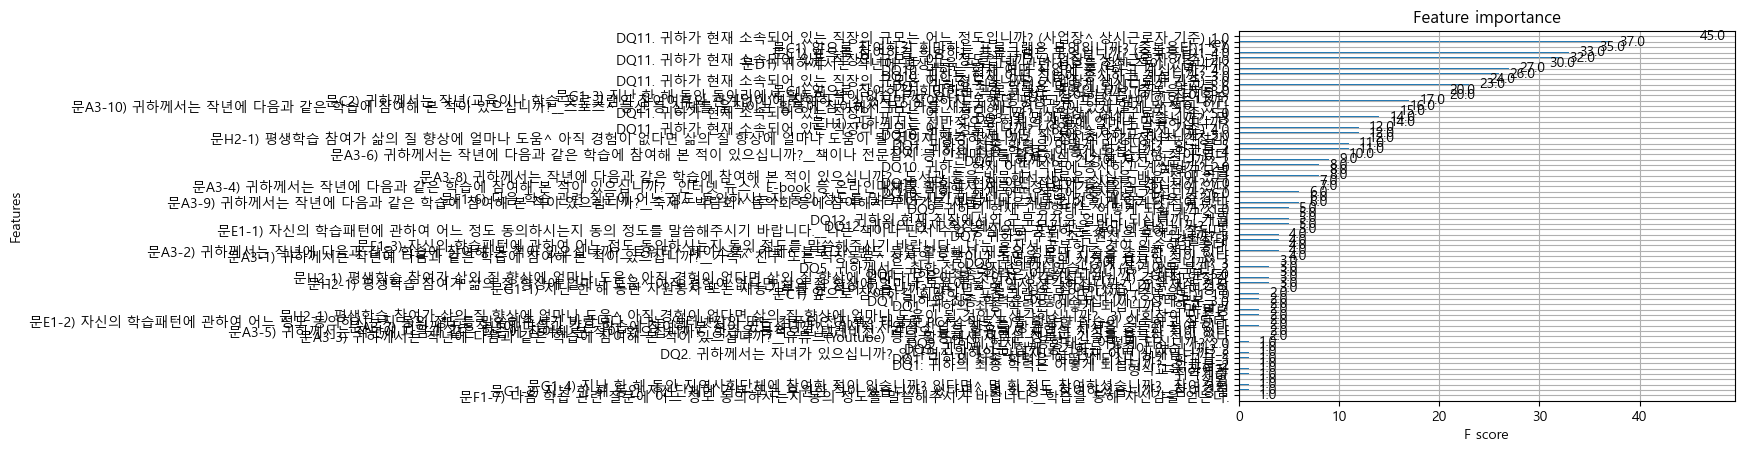

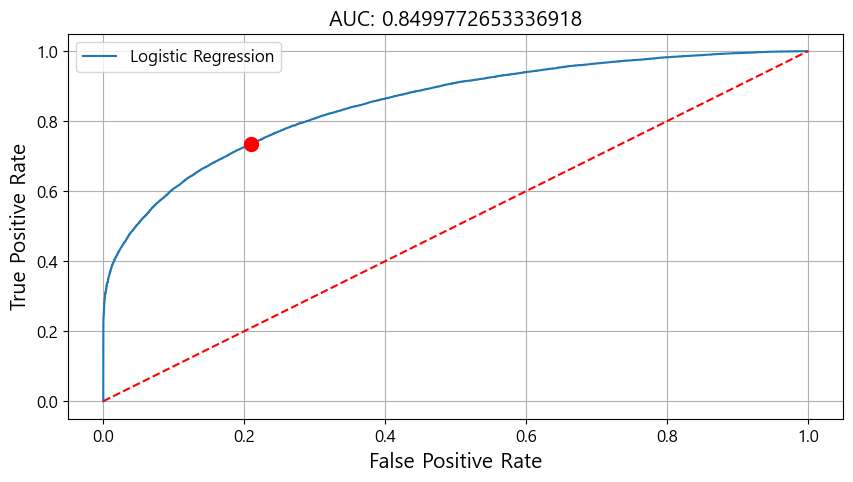

ROC Curve: Test


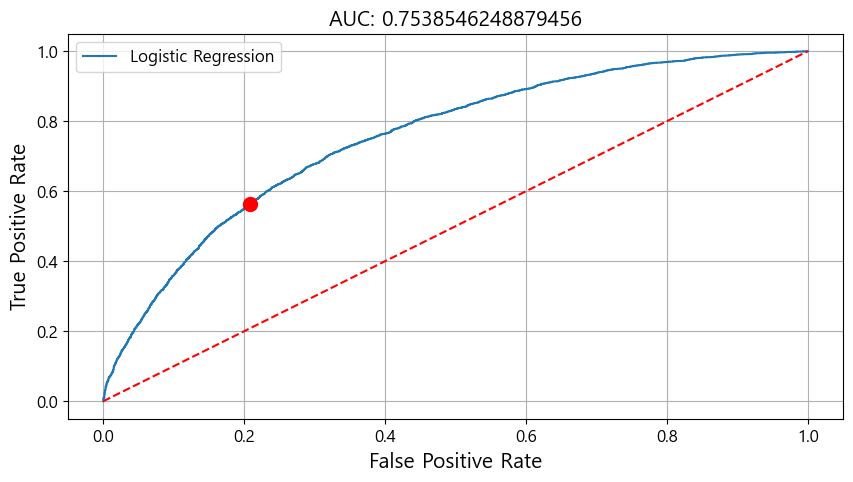

Precision-Recall Curve: Train


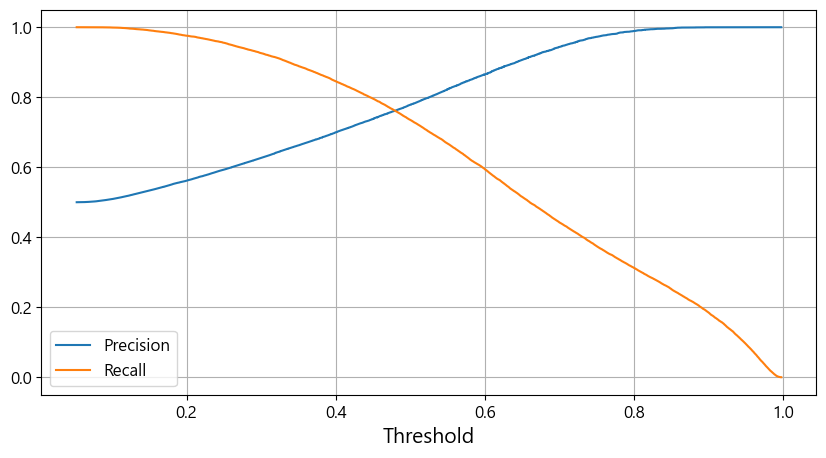

Precision-Recall Curve: Test


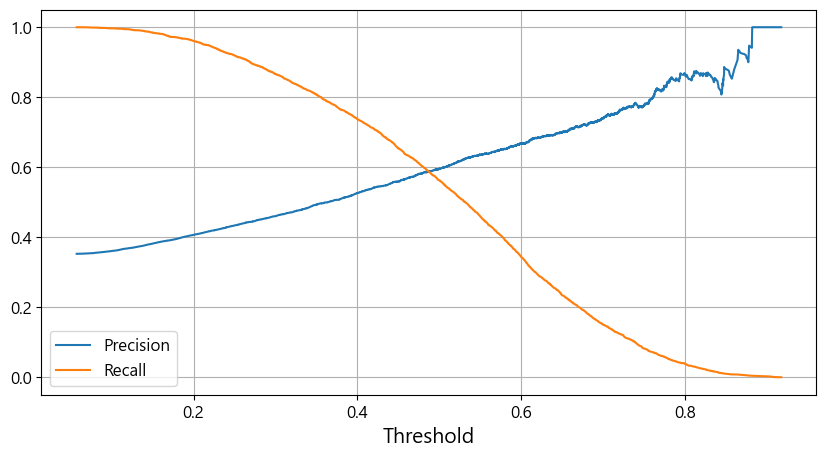

Accuracy & ROC AUC Summary


,Accuracy,ROC_AUC
Train,0.76296,0.84998
Test,0.71112,0.75385


In [19]:
Y_colname = '비형식교육 참여자'
test_size = 0.2
random_state = 123
sampling_strategy = 'auto'
SAMPLING_METHOD = 'RandomUnderSampler'
SAMPLING_STRATEGY = 'auto'
numeric_columns = [
    'DQ3. 몇 명과 함께 지내고 있습니까?__명',
    'DQ12. 귀하의 현재 직장에서의 근무기간은 얼마나 되십니까?__년',
    'DQ12. 귀하의 현재 직장에서의 근무기간은 얼마나 되십니까?__개월'
]
# DQ컬럼과 중복
deleted_cols = ['학력별', '자녀유무 및 막내자녀 상태', '동거가족 유무', '부양가족 유무', '취학 전의 손자/손녀 유무', '건강에 대한 자신감', '고용형태', '직업', '직장의 규모', '근무기간']

# 데이터로딩 및 데이터 불러오기    
df = pd.read_csv('./df_prep.csv', encoding='utf-8-sig')

# 더미 생성
dq_cat_cols = [col for col in df.columns if col.startswith('DQ') and col not in numeric_columns]
dummy_cols = dq_cat_cols + ['문C1) 앞으로 참여하길 희망하는 프로그램은 무엇입니까? (중복응답)1']
df = pd.get_dummies(df, columns=dummy_cols, drop_first=True)
df.drop(columns=deleted_cols, inplace=True)

X_train_scaled, X_test_scaled, Y_train, Y_test = preprocessing_Engagement(df)

# XGBoost
model_xgb = XGBClassifier(n_estimators=100,
                          learning_rate=0.1,
                          max_depth=3, random_state=123,
                          eval_metric='mlogloss')
model_xgb.fit(X_train_scaled, Y_train)
print("변수 중요도(분류기준): ")
display(pd.DataFrame(model_xgb.feature_importances_, 
                     index=model_xgb.feature_names_in_, columns=['Importance']))
print("변수 중요도(성능기준): ")
plot_importance_xgb(model_xgb)

# 예측
Y_trpred = model_xgb.predict(X_train_scaled)
Y_tepred = model_xgb.predict(X_test_scaled)
P_trpred = model_xgb.predict_proba(X_train_scaled)
P_tepred = model_xgb.predict_proba(X_test_scaled)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred[:,1])

print('Accuracy & ROC AUC Summary')
display(evaluation_class_AccuracyAUC_trte(Y_train, P_trpred[:,1], Y_test, P_tepred[:,1]))

## shap 도표

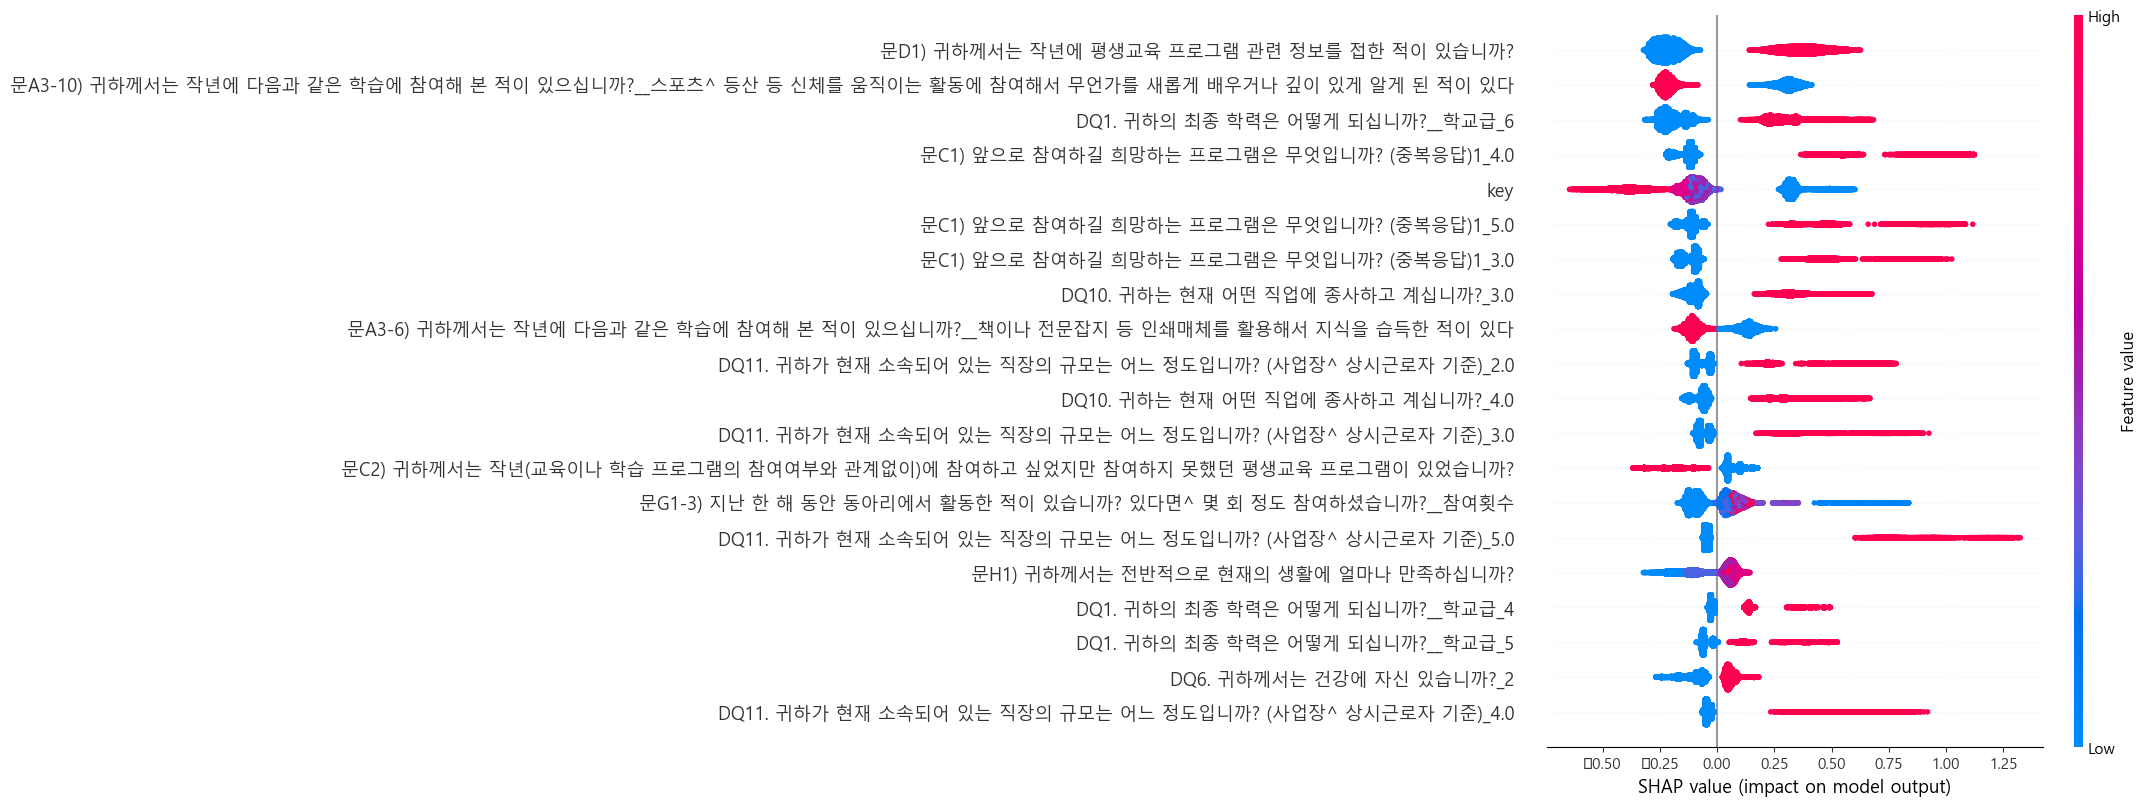

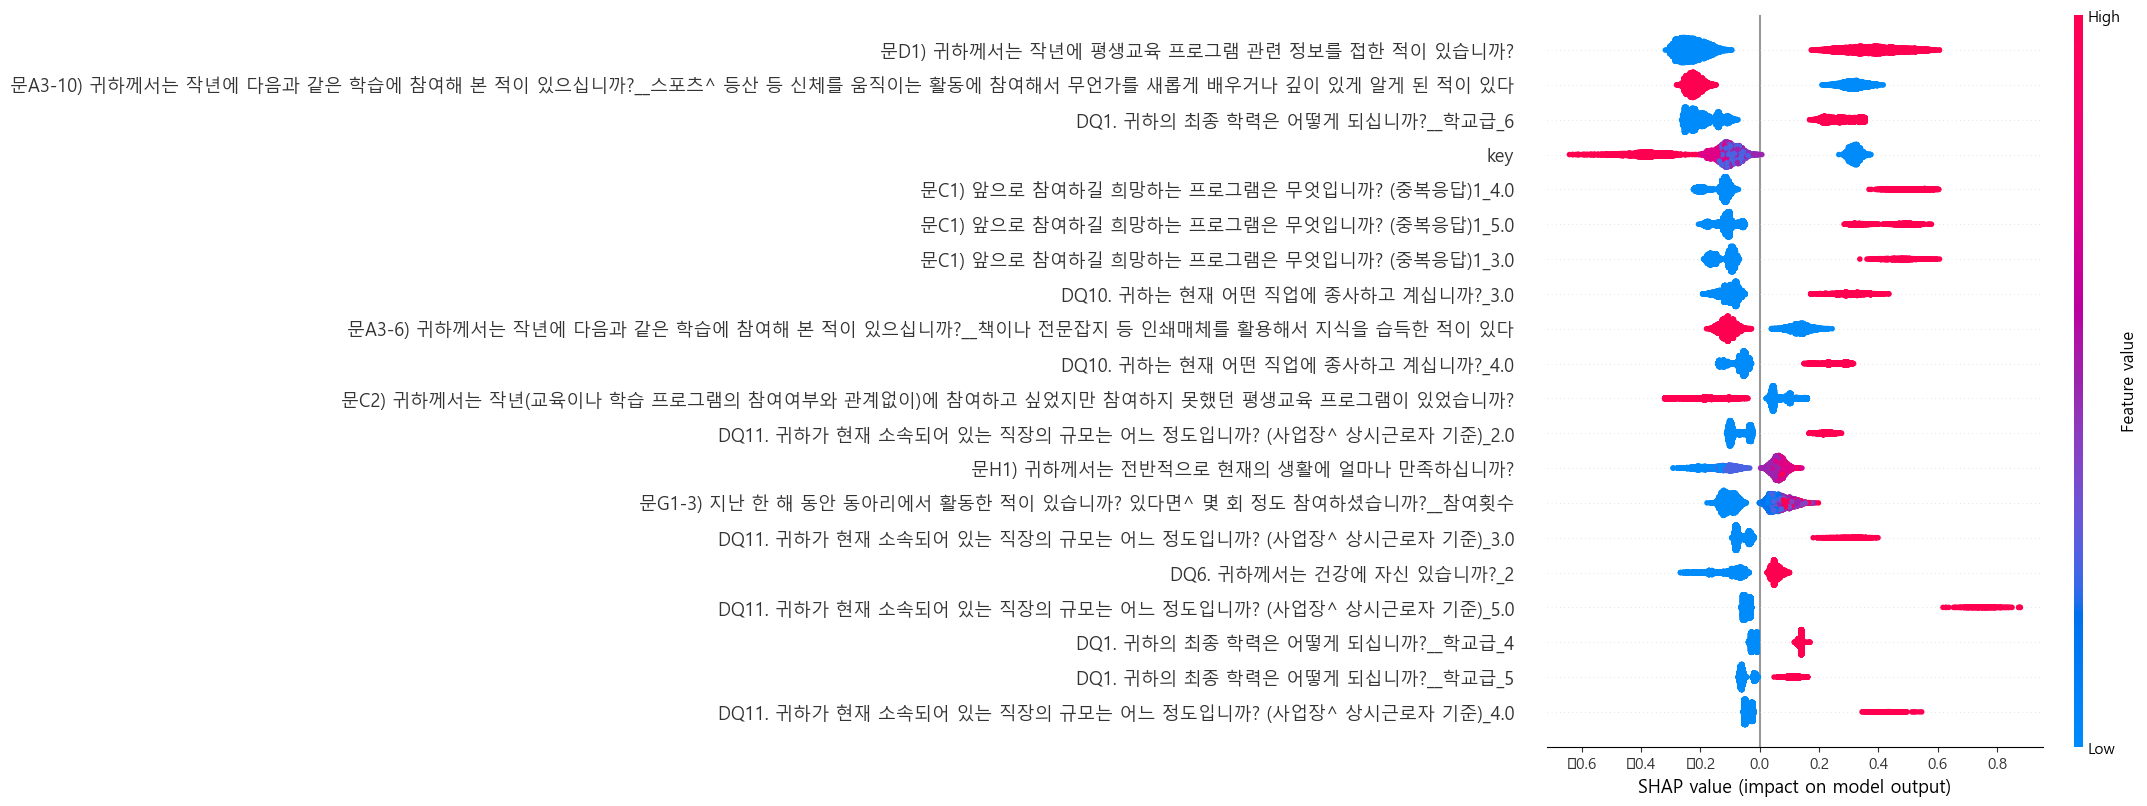

In [7]:
shap.initjs()

# 설명 모델 생성
explainer = shap.TreeExplainer(model_xgb)
# 트레인 셋에서의 SHAP value
shap_values_train = explainer.shap_values(X_train_scaled)
# 테스트 셋에서의 SHAP value
shap_values_test = explainer.shap_values(X_test_scaled)

#트레이닝 데이터의 SHAP Summary plot
shap.summary_plot(shap_values_train,X_train_scaled) 
 
#테스트 데이터의 SHAP Summary plot
shap.summary_plot(shap_values_test,X_test_scaled)